In [ ]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import font_manager

In [ ]:
sns.set_theme(style='whitegrid')

# Add Georgia font in georgia-2 folder
font_manager.fontManager.addfont('arial/ARIAL.TTF')

In [44]:
# 1) NVIDIA font style
rcParams.update({
    "font.family": "Serif",
    "font.size": 14,
    "axes.titlesize": 16,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12
})

# 2) Parse time.txt
pattern = re.compile(
    r'(?P<version>\d+)\s+'
    r'(?P<threads>\d+)\s+'
    r'(?P<particle>\d+)\s+'
    r'(?P<iteration>\d+):\s+'
    r'(?P<time_ms>[\d\.]+)ms'
)

records = []
with open('time.txt', 'r') as f:
    for line in f:
        m = pattern.match(line.strip())
        if m:
            d = m.groupdict()
            records.append({
                'version': int(d['version']),
                'threads': int(d['threads']),
                'particle': int(d['particle']),
                'time_ms': float(d['time_ms'])
            })

df = pd.DataFrame(records)

# 3) Compute mean over the 30 iterations
mean_df = (
    df
    .groupby(['version', 'threads', 'particle'], as_index=False)
    .time_ms
    .mean()
    .rename(columns={'time_ms': 'mean_ms'})
)

# 4) Prepare plotting parameters
versions = sorted(mean_df.version.unique())
threads = sorted(mean_df.threads.unique())
workloads = {
    'high': 60000,
    'medium': 16000,
    'low': 2000    
}

colors = ['#76B900', '#59A14F', '#2E7D32']  # NVIDIA‐like greens
markers = ['o', 's', '^']

threads_plot = np.array(threads)

# # 5) Create subplots: one per workload
# fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# for ax, (wl_name, pnum) in zip(axes, workloads.items()):
#     for version, color, m in zip(versions, colors, markers):
#         sub = mean_df[
#             (mean_df.version == version) &
#             (mean_df.particle == pnum)
#         ].sort_values('threads')
#         ax.plot(
#             sub.threads,
#             sub.mean_ms,
#             marker=m,
#             linestyle='-',
#             label=f'Version {version}',
#             color=color,
#             markerfacecolor='white',
#             markeredgewidth=2,
#             linewidth=2
#         )

#     # Styling each axes
#     ax.set_title(f"{wl_name.title()} Workload (N={pnum})")
#     ax.set_xlabel("Threads per Block")
#     if wl_name == 'low':
#         ax.set_ylabel("Mean Time (ms)")
#     ax.tick_params(axis='x', which='both', length=5, width=1.2, color='black')
#     ax.grid(axis='x', visible=False)
#     ax.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
#     for spine in ax.spines.values():
#         spine.set_visible(True)
#         spine.set_linewidth(2.5)
#         spine.set_edgecolor("black")

# # Shared legend and layout
# axes[2].legend(loc='upper left', bbox_to_anchor=(1, 1))
# plt.tight_layout()
# plt.show()


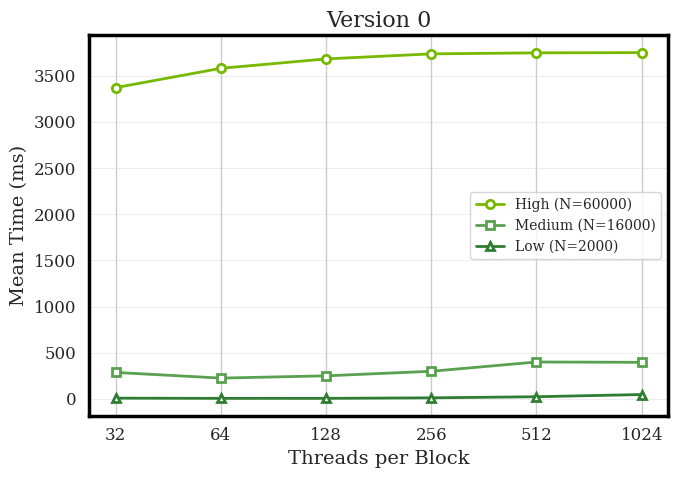

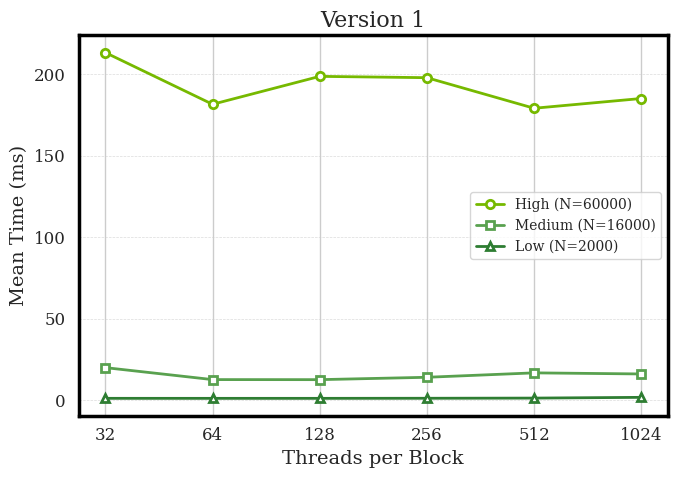

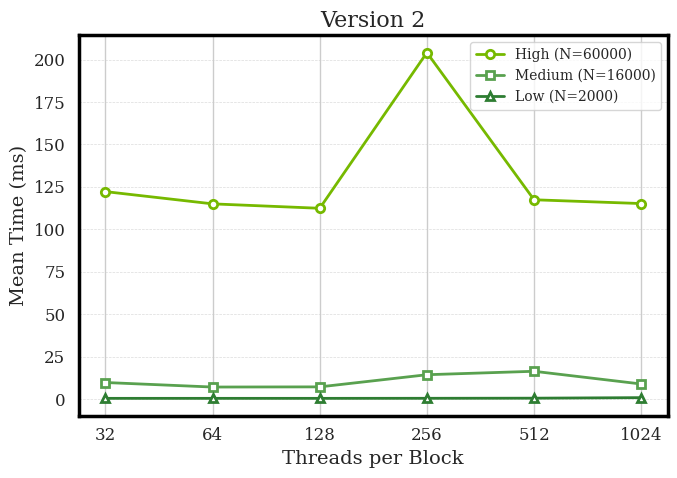

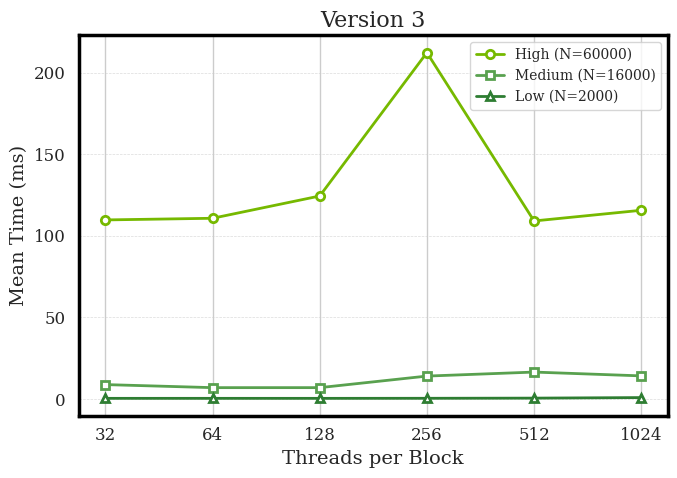

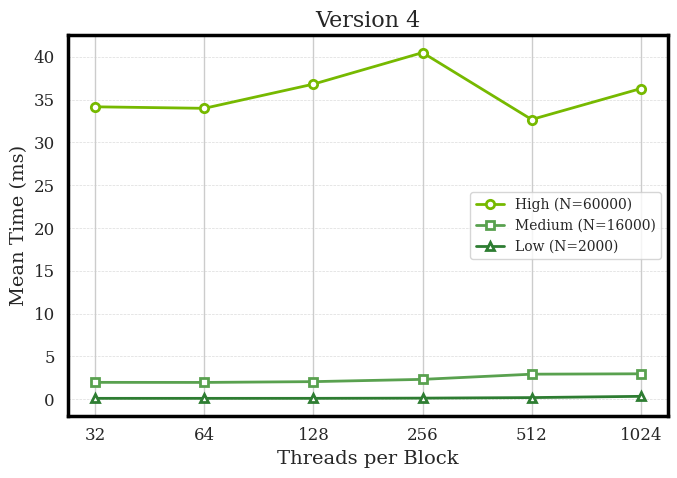

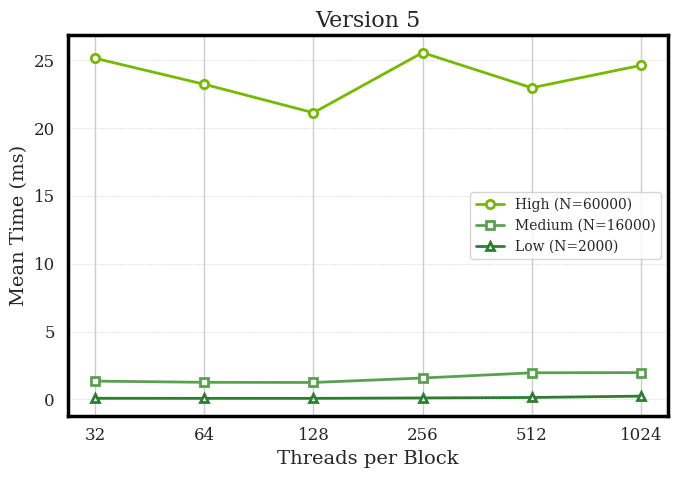

In [45]:
for version in versions:
    v_df = mean_df[mean_df.version == version]
    fig, ax = plt.subplots(figsize=(7, 5))
    for (wl_name, pnum), color, marker in zip(workloads.items(), colors, markers):
        sub = v_df[v_df.particle == pnum].set_index('threads').reindex(threads_plot).reset_index()
        ax.plot(
            sub['threads'], sub['mean_ms'],
            marker=marker,
            linestyle='-',
            label=f"{wl_name.title()} (N={pnum})",
            color=color,
            markerfacecolor='white',
            markeredgewidth=2,
            linewidth=2
        )
    ax.set_xscale('log', base=2)
    ax.set_xticks(threads_plot)
    ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())
    ax.tick_params(axis='x', which='both', length=5, width=1.2, color='black')
    ax.set_xlabel("Threads per Block")
    ax.set_ylabel("Mean Time (ms)")
    ax.set_title(f"Version {version}")
    ax.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(2.5)
        spine.set_edgecolor("black")
    ax.legend(fontsize=10)
    ax.autoscale(enable=True, axis='y')
    plt.tight_layout()
    plt.show()


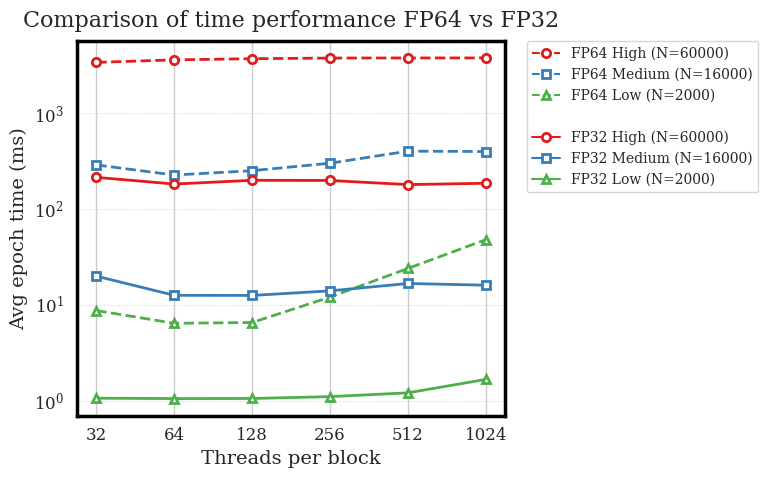

In [46]:
from matplotlib.lines import Line2D

# Plot version 0 and 1 together (logarithmic scale on both axes)
fig, ax = plt.subplots(figsize=(8, 5))

distinct_colors = ['#E41A1C', '#377EB8', '#4DAF4A']  # red, blue, green

FP = {
    "0": "FP64",
    "1": "FP32"
}

legend_handles_fp64 = []
legend_handles_fp32 = []

for version, style in zip([0, 1], ['dashed', 'solid']):
    v_df = mean_df[mean_df.version == version]
    for (wl_name, pnum), color, marker in zip(workloads.items(), distinct_colors, markers):
        sub = v_df[v_df.particle == pnum].set_index('threads').reindex(threads_plot).reset_index()
        ax.plot(
            sub['threads'], sub['mean_ms'],
            marker=marker,
            linestyle=style,
            label=f"{FP[str(version)]} {wl_name.title()} (N={pnum})",
            color=color,
            markerfacecolor='white',
            markeredgewidth=2,
            linewidth=2
        )
        handle = Line2D(
            [0], [0],
            color=color,
            marker=marker,
            linestyle='--' if style == 'dashed' else 'solid',
            markerfacecolor='white',
            markeredgewidth=2,
            linewidth=1.5,
            label=f"{FP[str(version)]} {wl_name.title()} (N={pnum})"
        )
        if version == 0:
            legend_handles_fp64.append(handle)
        else:
            legend_handles_fp32.append(handle)

# Add a blank handle for spacing
blank = Line2D([0], [0], color='none', label='')

# Combine handles: FP64, blank, FP32
all_handles = legend_handles_fp64 + [blank] + legend_handles_fp32
all_labels = [h.get_label() for h in legend_handles_fp64] + [''] + [h.get_label() for h in legend_handles_fp32]

ax.set_xscale('log', base=2)
ax.set_yscale('log')
ax.set_xticks(threads_plot)
ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())
ax.tick_params(axis='x', which='both', length=5, width=1.2, color='black')
ax.set_xlabel("Threads per block")
ax.set_ylabel("Avg epoch time (ms)")
ax.set_title("Comparison of time performance FP64 vs FP32", pad=10)
ax.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(2.5)
    spine.set_edgecolor("black")

# Unified legend with spacing
ax.legend(
    handles=all_handles,
    labels=all_labels,
    fontsize=10,
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0.,
)

ax.autoscale(enable=True, axis='y')
plt.tight_layout()
plt.show()

In [ ]:
# Font stile NVIDIA
rcParams.update({
    "font.family": "Georgia",
    "font.size": 14,
    "axes.titlesize": 16,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12
})

# Dati simulati: performance di 3 versioni
x = np.array([32, 64, 96, 128, 160, 192, 224, 256])
fps_v1 = 1000 / (25 + 0.03 * (x - 128)) + np.random.normal(scale=0.5, size=len(x))
fps_v2 = 1000 / (24 + 0.025 * (x - 128)) + np.random.normal(scale=0.5, size=len(x))
fps_v3 = 1000 / (23 + 0.02 * (x - 128)) + np.random.normal(scale=0.5, size=len(x))

# Colori NVIDIA-like
colors = ['#76B900', '#59A14F', '#2E7D32']  # Verde NVIDIA, verde oliva, verde scuro

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(x, fps_v1, '-o', label='Version 1', color=colors[0],
        markerfacecolor='white', markeredgewidth=2, linewidth=2)
ax.plot(x, fps_v2, '-s', label='Version 2', color=colors[1],
        markerfacecolor='white', markeredgewidth=2, linewidth=2)
ax.plot(x, fps_v3, '-^', label='Version 3', color=colors[2],
        markerfacecolor='white', markeredgewidth=2, linewidth=2)

# Titoli e legenda
ax.set_xlabel("Threads per Block")
ax.set_ylabel("FPS")
ax.set_title("Performance Comparison – NVIDIA Style")
ax.legend()

# Tick asse X: numeri visibili con linette nere
ax.tick_params(axis='x', which='both', length=5, width=1.2, color='black', labelbottom=True)

# Griglia: solo orizzontale
ax.grid(axis='x', visible=False)
ax.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)

# Bordi neri e spessi
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(2.5)
    spine.set_edgecolor("black")

plt.tight_layout()
plt.show()

In [ ]:
# Imposta font e dimensioni globali
rcParams.update({
    "font.family": "Georgia",
    "font.size": 14,
    "axes.titlesize": 16,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12
})

# Simula dati
np.random.seed(42)
x = np.random.choice([0, 1, 2, 3], size=100)
data = pd.DataFrame({"x": x})

# Conta frequenze
counts = data["x"].value_counts().sort_index()
bars = counts.index
values = counts.values

# Colori e hatch
colors = ["#76B900", "#4CAF50", "#2E7D32", "#66BB6A"]
labels = ['Group A', 'Group B', 'Group C', 'Group D']
hatches = ['//', 'xx', '//', 'xx']

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
for i in range(len(bars)):
    ax.bar(bars[i], values[i], color=colors[i], hatch=hatches[i], label=labels[i])

# Etichette
ax.set_xlabel("Category")
ax.set_ylabel("Frequency")
ax.set_title("Histogram with Clean Look and Georgia Font")
ax.legend()

# Bordi neri e spessi
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(2.5)
    spine.set_edgecolor("black")

# Tick X: linette visibili ma senza etichette
ax.tick_params(axis='x', which='both', length=5, width=1.2, color='black', labelbottom=False)

# Disattiva griglia verticale, lascia (eventualmente) solo quella orizzontale
ax.grid(axis='x', visible=False)

plt.tight_layout()
plt.show()

In [ ]:

# Font stile Intel
rcParams.update({
    "font.family": "Georgia",
    "font.size": 14,
    "axes.titlesize": 16,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12
})

# Dati
np.random.seed(0)
x = np.random.choice([0, 1, 2, 3], size=100)
data = pd.DataFrame({"x": x})
counts = data["x"].value_counts().sort_index()
bars = counts.index
values = counts.values

# Colori blu/grigio Intel-like
colors = ["#0071C5", "#A6A6A6", "#003C71", "#C6C6C6"]
labels = ["Core A", "Core B", "Core C", "Core D"]
hatches = ["//", "xx", "//", "xx"]

fig, ax = plt.subplots(figsize=(8, 5))
for i in range(len(bars)):
    ax.bar(bars[i], values[i], color=colors[i], hatch=hatches[i], label=labels[i])

# Titolo e assi
ax.set_xlabel("Logical Core")
ax.set_ylabel("Frequency")
ax.set_title("Histogram - Intel Style")
ax.legend()

# Bordi neri spessi
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(2.5)
    spine.set_edgecolor("black")

# Ticks: visibili, etichette disattivate
ax.tick_params(axis='x', which='both', length=5, width=1.2, color='black', labelbottom=False)
ax.grid(axis='x', visible=False)

plt.tight_layout()
plt.show()

In [ ]:

# Font stile Intel
rcParams.update({
    "font.family": "Georgia",
    "font.size": 14,
    "axes.titlesize": 16,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12
})

# Dati (simulati): 3 versioni di un algoritmo
x = np.array([32, 64, 96, 128, 160, 192, 224, 256])
fps_v1 = 1000 / (25 + 0.03 * (x - 128)) + np.random.normal(scale=0.5, size=len(x))
fps_v2 = 1000 / (24 + 0.025 * (x - 128)) + np.random.normal(scale=0.5, size=len(x))
fps_v3 = 1000 / (23 + 0.02 * (x - 128)) + np.random.normal(scale=0.5, size=len(x))

# Colori in stile Intel
colors = ['#0071C5', '#00A1F1', '#003C71']  # blu, azzurro, blu scuro

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(x, fps_v1, '-o', label='Algorithm V1', color=colors[0],
        markerfacecolor='white', markeredgewidth=2, linewidth=2)
ax.plot(x, fps_v2, '-s', label='Algorithm V2', color=colors[1],
        markerfacecolor='white', markeredgewidth=2, linewidth=2)
ax.plot(x, fps_v3, '-^', label='Algorithm V3', color=colors[2],
        markerfacecolor='white', markeredgewidth=2, linewidth=2)

# Etichette e legenda
ax.set_xlabel("Threads per Core")
ax.set_ylabel("FPS")
ax.set_title("Performance Comparison – Intel Style")
ax.legend()

# Tick asse X: visibili, con linette
ax.tick_params(axis='x', which='both', length=5, width=1.2, color='black', labelbottom=True)

# Griglia: solo asse Y
ax.grid(axis='x', visible=False)
ax.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)

# Bordi neri spessi su tutti i lati
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(2.5)
    spine.set_edgecolor("black")

plt.tight_layout()
plt.show()

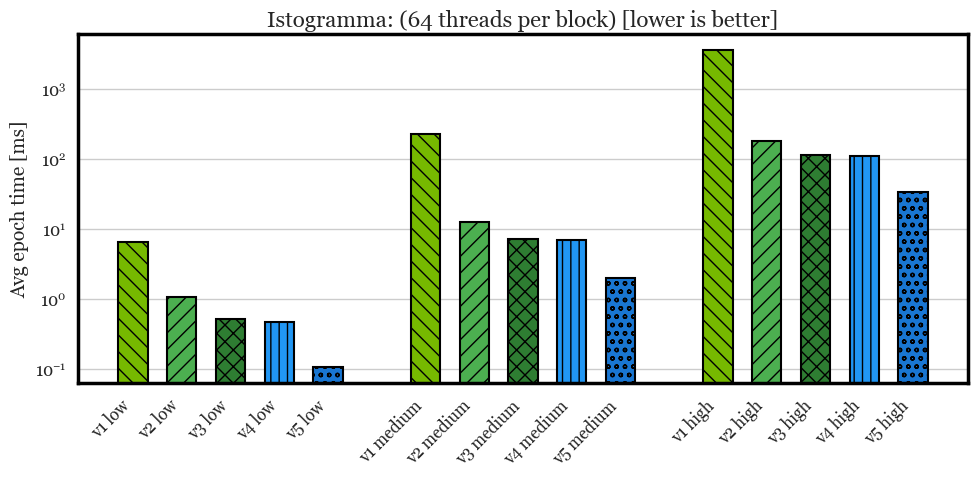

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Istogramma (scala log) dei tempi medi: barre raggruppate per versione,
con etichette leggibili e scala logaritmica.
"""

import re
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams

# ╔════════════════════════ PARAMETRI ═══════════════════════╗
THREADS_PER_BLOCK = 64
N_VERSIONI        = 5
FILE_PATH         = "time.txt"
BAR_WIDTH         = 0.6
GROUP_GAP         = 1.0
PARTICLE_LABELS   = {2000: "low", 16000: "medium", 60000: "high"}
# ╚══════════════════════════════════════════════════════════╝

# ─────────────── Lettura file ───────────────
rows = []
pattern = re.compile(r"(\d+)\s+(\d+)\s+(\d+)\s+(\d+):\s+([\d.]+)ms")

with Path(FILE_PATH).open() as f:
    for line in f:
        m = pattern.match(line.strip())
        if m:
            vers, tpb, part, it, t = m.groups()
            rows.append({
                "version"        : int(vers),
                "threadsPerBlock": int(tpb),
                "particles"      : int(part),
                "iteration"      : int(it),
                "time_ms"        : float(t)
            })

df = pd.DataFrame(rows)

# ─────────────── Filtro ───────────────
df = df[df["threadsPerBlock"] == THREADS_PER_BLOCK]

# ─────────────── Media tempi ───────────────
media = df.groupby(["particles", "version"])["time_ms"].mean().reset_index()

# ─────────────── Preparazione dati ───────────────
particles_sorted = sorted(media["particles"].unique())
values, x_labels, x_pos = [], [], []

for g_idx, p in enumerate(particles_sorted):
    label_base = PARTICLE_LABELS.get(p, str(p))
    base = g_idx * (N_VERSIONI + GROUP_GAP)
    for v_idx in range(N_VERSIONI):
        mask = (media["particles"] == p) & (media["version"] == v_idx)
        if mask.any():
            val = media.loc[mask, "time_ms"].iat[0]
            values.append(val)
            x_labels.append(f"v{v_idx+1} {label_base}")
            x_pos.append(base + v_idx)

# ─────────────── Stile ───────────────
rcParams.update({
    "font.family": "Georgia",
    "font.size": 14,
    "axes.titlesize": 16,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12
})

# ─────────────── Colori & Hatch ───────────────
base_colors = [
    "#76B900", "#4CAF50", "#2E7D32", "#2196F3", "#1976D2",
    "#F9A825", "#F44336", "#9C27B0", "#FF9800", "#009688"
]

base_hatch = [
    "\\\\", "//", "xx", "||", "oo", "--", "++", "..", "**", "OO"
]

base_colors = base_colors[:N_VERSIONI]
base_hatch  = base_hatch[:N_VERSIONI]

colors  = (base_colors * ((len(values) // len(base_colors)) + 1))[:len(values)]
hatches = (base_hatch  * ((len(values) // len(base_hatch )) + 1))[:len(values)]

# ─────────────── Plot ───────────────
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_yscale("log")

for i, (x, val) in enumerate(zip(x_pos, values)):
    ax.bar(x, val,
           width=BAR_WIDTH,
           color=colors[i],
           hatch=hatches[i],
           edgecolor="black",
           linewidth=1.5)

ax.set_ylabel("Avg epoch time [ms]")
ax.set_title(f"{THREADS_PER_BLOCK} threads per block [lower is better]")

# Etichette composite vN + livello (es. v1\nlow)
ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels, rotation=45, ha='right')

# Bordi
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(2.5)
    spine.set_edgecolor("black")

ax.tick_params(axis='y', length=5, width=1.2, color='black')
ax.grid(axis='x', visible=False)

plt.tight_layout()
plt.show()
